In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from scipy.stats import binned_statistic
from scipy.signal import correlation_lags

In [2]:
genotype = 'R60D05>sytGCaMP7f'
celltype = 'EPG-syt7f-EB'
trial_condition = 'cl'

In [3]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude_V3, calcualteBumpAmplitude_V4 

In [4]:
pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dark_cl_Ca_imaging/delta7/delta7_PB/dark')
count = 0
output_crossc_pooled = []
lagged_Bump_amplitude_z_smooth_pooled = []
Angular_speed_pooled = []
for single_df in os.listdir(pooled_directory):
    if 'TQfly025' in single_df:
        current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
        #Get time info
        volume_cycle = len(current_file )
        volume_time = current_file['Time_Stamp'][1]
        volume_rate = 1/volume_time
        time_array_imaging = np.arange(volume_cycle)/volume_rate
        #Get necessary parameters
        PVA_Unwrapped_Radian = current_file['Unwrapped_Radian']
        PVA_Angle = current_file['PVA_Angle']
        PVA_Radian = current_file['PVA_Radian']
        Angular_velocity = current_file['Angular_Velocity']
        PVA_strength = current_file['PVA_strength']
        Bump_amplitude = current_file['Bump_amplitude']
        Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading']
    
        dff_normalized_8_roi = np.zeros((len(current_file['dFF_Roi_1']), 8))
        dff_normalized_8_roi_shifted = np.zeros((len(current_file['dFF_Roi_1']), 8))
        for i in range(len(current_file['F_Roi_1'])):
            dff_normalized_8_roi[i,0]= current_file['dFF_Roi_1'][i]
            dff_normalized_8_roi[i,1]= current_file['dFF_Roi_2'][i]
            dff_normalized_8_roi[i,2]= current_file['dFF_Roi_3'][i]
            dff_normalized_8_roi[i,3]= current_file['dFF_Roi_4'][i]
            dff_normalized_8_roi[i,4]= current_file['dFF_Roi_5'][i]
            dff_normalized_8_roi[i,5]= current_file['dFF_Roi_6'][i]
            dff_normalized_8_roi[i,6]= current_file['dFF_Roi_7'][i]
            dff_normalized_8_roi[i,7]= current_file['dFF_Roi_8'][i]
            dff_normalized_8_roi_shifted[i,0]= current_file['dFF_Roi_5'][i]
            dff_normalized_8_roi_shifted[i,1]= current_file['dFF_Roi_6'][i]
            dff_normalized_8_roi_shifted[i,2]= current_file['dFF_Roi_7'][i]
            dff_normalized_8_roi_shifted[i,3]= current_file['dFF_Roi_8'][i]
            dff_normalized_8_roi_shifted[i,4]= current_file['dFF_Roi_1'][i]
            dff_normalized_8_roi_shifted[i,5]= current_file['dFF_Roi_2'][i]
            dff_normalized_8_roi_shifted[i,6]= current_file['dFF_Roi_3'][i]
            dff_normalized_8_roi_shifted[i,7]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi_shifted = dff_normalized_8_roi_shifted.transpose()
        #Need no series array for function below 
        PVA_Unwrapped_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        PVA_Angle_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        PVA_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        Angular_velocity_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        PVA_strength_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        Bump_amplitude_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        Unwrapped_heading_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
        for i in range(len(current_file['Unwrapped_Radian'])):
            PVA_Unwrapped_Radian_no_series[i] = current_file['Unwrapped_Radian'][i]
            PVA_Angle[i] = current_file['PVA_Angle'][i]
            PVA_Angle_no_series[i] = current_file['PVA_Angle'][i]
            Angular_velocity_no_series[i] = current_file['Angular_Velocity'][i]
            PVA_strength_no_series[i] = current_file['PVA_strength'][i]
            Bump_amplitude_no_series[i] = current_file['Bump_amplitude'][i]
            Unwrapped_heading_no_series[i] = current_file['Unwrapped_Bar_Position/Heading'][i]
            PVA_Radian_no_series[i] = current_file['PVA_Radian'][i]
        
        Angular_speed_degrees =  np.abs(Angular_velocity) * 180/np.pi
        #Get persistence period
        persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
        #Calculate annd plot difference throughout the stop period
        difference_during_stop = []
        current_difference_during_stop = []
        #plt.figure(figsize= (25,7))
        for current_index in range(len(persistence_stop_index_and_length)):
            current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
            current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
            current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
            #Modify the value so angle difference will never be different more than 180 degrees
            for j in range(len(current_difference_during_stop)):
                if np.abs(current_difference_during_stop[j]) > 180:
                    if current_difference_during_stop[j] < 0:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                    else:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
            difference_during_stop.append(current_difference_during_stop)
    
        # calculate bump amplitude by getting the normalized dff at current PVA angle 
        Bump_amplitude_V3, Bump_amplitude_V3_opposite = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian_no_series)
        Bump_amplitude_V4 =  calcualteBumpAmplitude_V4(Bump_amplitude_V3,dff_normalized_8_roi,PVA_Radian_no_series,persistence_stop_index_and_length)
    
        Bump_amplitude_smooth_for_speed_cor_V3 = gaussian_filter1d(Bump_amplitude_V3, sigma =5)
        Bump_amplitude_smooth_for_speed_cor_V4 = gaussian_filter1d(Bump_amplitude_V4, sigma =5)
        Bump_amplitude_z_smooth_for_speed_cor_V3 = zscore(Bump_amplitude_smooth_for_speed_cor_V3)
        Bump_amplitude_z_smooth_for_speed_cor_V4 = zscore(Bump_amplitude_smooth_for_speed_cor_V4)
    
    
    
   
        # Calculate cross-correlation within the allowed lags range
        cross_corr = correlate(Angular_speed_degrees, Bump_amplitude_z_smooth_for_speed_cor_V3, mode='full')
        lags = correlation_lags(Angular_speed_degrees.size,  Bump_amplitude_z_smooth_for_speed_cor_V3.size, mode="full")
                                  
        #find the middle index to consider the frame on both side till max shift frame (1s)
        max_shift_frame = int(volume_rate)
        middle_index = int(len(lags)/2)
        lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        correlation_short = cross_corr[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        lag = lags_short[np.argmax(correlation_short)]
        if lag > 0:
            lag = lags_short[np.argmax(correlation_short[0:int((len(correlation_short)-1)/2+1)])]
        lag = int(-0.4/volume_time)
        output_crossc_pooled.append(lag*volume_time)
     
        # Apply the lag only to Bump_amplitude_z_smooth_for_speed_cor
    
        #shift back tne bump_amplitude by drop the lag frame at the beginning
        lagged_Bump_amplitude_z_smooth_for_speed_cor = Bump_amplitude_z_smooth_for_speed_cor_V3[-lag:]
        Angular_speed_degrees = Angular_speed_degrees[:len(lagged_Bump_amplitude_z_smooth_for_speed_cor)]
    
    
        if count == 0:
            lagged_Bump_amplitude_z_smooth_pooled = lagged_Bump_amplitude_z_smooth_for_speed_cor
            Angular_speed_pooled  = Angular_speed_degrees
        else:
            lagged_Bump_amplitude_z_smooth_pooled = np.concatenate((lagged_Bump_amplitude_z_smooth_pooled ,lagged_Bump_amplitude_z_smooth_for_speed_cor))
            Angular_speed_pooled  = np.concatenate((Angular_speed_pooled,Angular_speed_degrees))
        count = count + 1

In [5]:
output_crossc_pooled

[-0.3508799999999997]

In [6]:
Angular_speed_pooled.shape

(2562,)

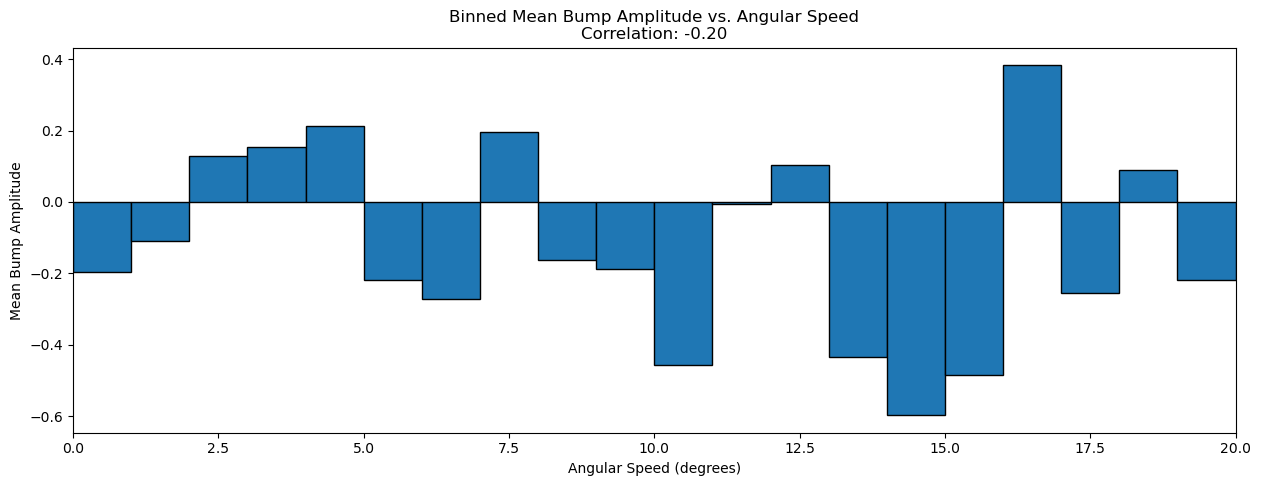

In [7]:
# Define the bin edges with a bin width of 5
bin_width = 1
bin_edges = np.arange(0, 20 + bin_width, bin_width)

# Use scipy's binned_statistic to calculate the mean bump amplitude for each bin
binned_stats = binned_statistic(Angular_speed_pooled, lagged_Bump_amplitude_z_smooth_pooled, statistic='mean', bins=bin_edges)

# Extract the mean bump amplitude and bin centers
mean_bump_amplitude_per_bin = binned_stats.statistic
bin_centers = binned_stats.bin_edges[:-1] + 0.5 * bin_width

# Exclude bins with no data points
valid_bins = ~np.isnan(mean_bump_amplitude_per_bin)

# Calculate the correlation between mean bump amplitude and bin centers for valid bins
correlation_coefficient = np.corrcoef(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins])[0, 1]

# Plot the binned mean bump amplitude against the angular speed for valid bins
plt.figure(figsize=(15, 5))
plt.bar(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins], width=bin_width, align='center', edgecolor='black')
plt.xlim(0, np.max(bin_edges))  # Set the limit for angular speed
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Mean Bump Amplitude')
plt.title(f'Binned Mean Bump Amplitude vs. Angular Speed\nCorrelation: {correlation_coefficient:.2f}')
plt.show()

In [8]:
# Print the number of values in each bin
bin_numbers = binned_stats.binnumber
# Print the number of values in each bin
for i in range(1, len(np.unique(bin_numbers)) + 1):
    count = np.sum(bin_numbers == i)
    print(f'Bin {i}: {count} values')

Bin 1: 504 values
Bin 2: 183 values
Bin 3: 113 values
Bin 4: 65 values
Bin 5: 60 values
Bin 6: 42 values
Bin 7: 35 values
Bin 8: 29 values
Bin 9: 37 values
Bin 10: 38 values
Bin 11: 26 values
Bin 12: 26 values
Bin 13: 20 values
Bin 14: 20 values
Bin 15: 19 values
Bin 16: 24 values
Bin 17: 14 values
Bin 18: 18 values
Bin 19: 20 values
Bin 20: 17 values
Bin 21: 1252 values


In [9]:
mean_bump_amplitude_per_bin

array([-0.19576019, -0.10940157,  0.12854375,  0.15515823,  0.21387682,
       -0.21866216, -0.27033786,  0.19634409, -0.16144159, -0.18758152,
       -0.4556626 , -0.00502036,  0.10326487, -0.43424789, -0.59684352,
       -0.48293976,  0.38277006, -0.25464001,  0.09080617, -0.21800542])

In [10]:
# Convert the list to a DataFrame
df = pd.DataFrame({'Column Name': mean_bump_amplitude_per_bin})
# Save the DataFrame to a CSV file
#df.to_csv('/home/tianhaoqiu/Desktop/BA.csv', encoding='utf-8', index=False)

In [33]:
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Desktop/BA_v3_vs_AngularV_EPG_PB_syt_dark_0-20.csv')
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Desktop/BA_v3_vs_AngularV_delta7_PB_syt_dark_0-20.csv')

In [34]:
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [35]:
angular_speed_array = np.arange(0.5, 20.5, 1)

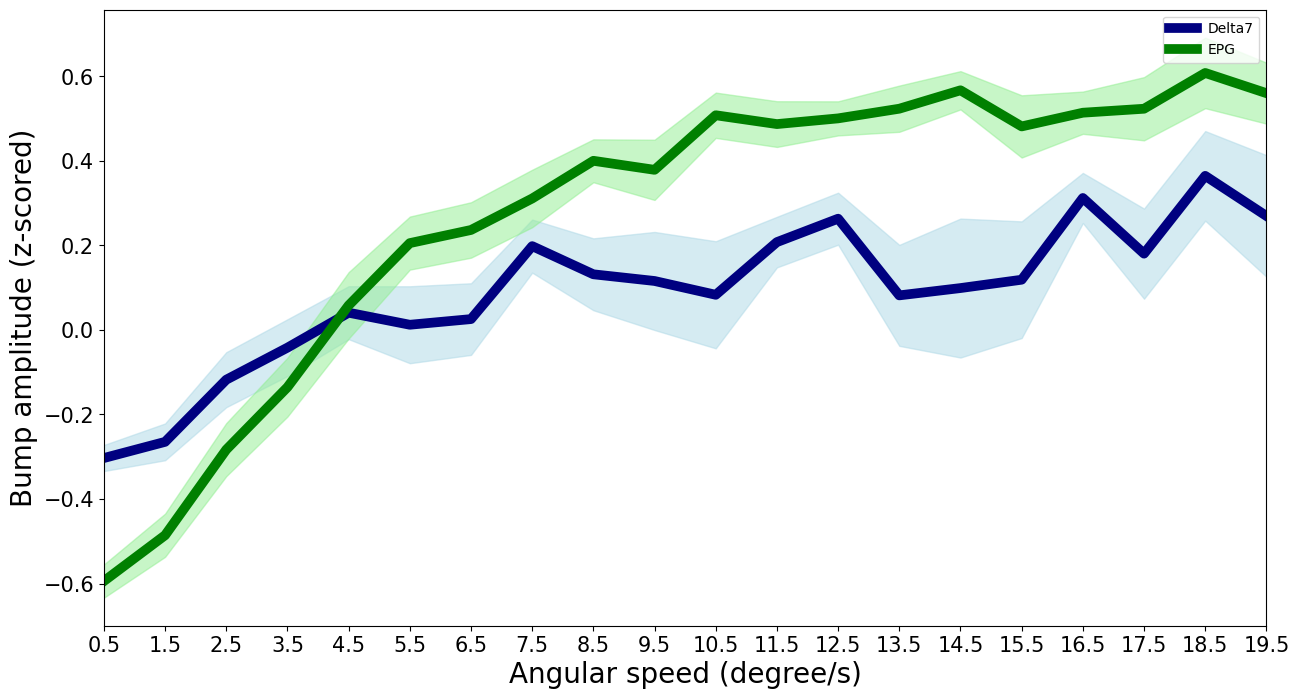

In [36]:
# Calculate mean and SEM for the first DataFrame (blue)
mean_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.mean(axis=1)
sem_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.sem(axis=1)

# Calculate mean and SEM for the second DataFrame (green)
mean_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.mean(axis=1)
sem_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.sem(axis=1)

# Plot mean and SEM for the first DataFrame (blue)
plt.figure(figsize=(15, 8))
plt.plot(mean_delta7, linewidth=7, color='navy', label='Delta7')
plt.fill_between(mean_delta7.index, mean_delta7 - sem_delta7, mean_delta7 + sem_delta7, color='lightblue', alpha=0.5)

# Plot mean and SEM for the second DataFrame (green)
plt.plot(mean_EPG, linewidth=7, color='green', label='EPG')
plt.fill_between(mean_EPG.index, mean_EPG - sem_EPG, mean_EPG + sem_EPG, color='lightgreen', alpha=0.5)


plt.xticks(mean_delta7.index,angular_speed_array,size = 15)
plt.yticks(size = 15)
plt.xlim(0,19)

# Set labels and title
plt.xlabel('Angular speed (degree/s)', size = 20)
plt.ylabel('Bump amplitude (z-scored)', size = 20)
#plt.title('Mean Bump Amplitude with SEM')
plt.legend()
plt.show()

In [37]:
delta7_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
EPG_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [38]:
for i in range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns)):
    delta7_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df[i])[0, 1]
for i in range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns)):
    EPG_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df[i])[0, 1]

In [39]:
 delta7_correlation_coefficient

array([-0.20492755, -0.20492755,  0.86592792,  0.89914247,  0.76046586,
        0.67858075,  0.85501889,  0.84262873])

In [40]:
EPG_correlation_coefficient

array([0.71829745, 0.79366715, 0.89705725, 0.88148312, 0.90235507,
       0.8080222 , 0.89242916, 0.82291184])

/tmp/ipykernel_1626583/1405352974.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)


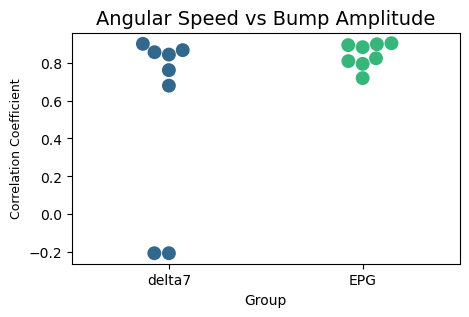

In [41]:

# Combine arrays and create a corresponding group array for swarmplot
data = np.concatenate([ delta7_correlation_coefficient, EPG_correlation_coefficient])
group = np.concatenate([['delta7'] * len(delta7_correlation_coefficient), ['EPG'] * len(EPG_correlation_coefficient)])

# Create a DataFrame for seaborn
df = pd.DataFrame({'Value': data, 'Group': group})

# Create swarmplot
plt.figure(figsize=(5, 3))
sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)

# Set labels and title
plt.ylabel('Correlation Coefficient',size =9)
plt.title('Angular Speed vs Bump Amplitude',size = 14)
plt.show()
